In [2]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Load data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Pivot ratings into movie features
df_movie_features = ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

# Convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)

# Create model using NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(mat_movie_features)

def get_movie_recommendation(movie_name):
    n_movies_to_recommend = 10

    # Filter movies by movie_name
    movie_list = movies[movies['title'].str.contains(movie_name)]

    if len(movie_list):
        # Get movie index
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = df_movie_features[df_movie_features.index == movie_idx].index[0]

        # Get k nearest neighbors
        distances, indices = model_knn.kneighbors(df_movie_features.iloc[movie_idx, :].values.reshape(1, -1), n_neighbors=n_movies_to_recommend+1)

        # Sort recommended movies by distance
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]

        # Create dataframe with recommended movies
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = df_movie_features.iloc[val[0]].name
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})

        df = pd.DataFrame(recommend_frame, index=range(1, n_movies_to_recommend+1))
        return df
    else:
        return "No movies found. Please check your input"


In [4]:
 get_movie_recommendation('Toy Story')

,Title,Distance
1,"Santa Clause, The (1994)",0.502632
2,Ace Ventura: When Nature Calls (1995),0.502440
3,Beauty and the Beast (1991),0.492542
4,Aladdin (1992),0.484380
5,"Nightmare Before Christmas, The (1993)",0.481839
6,Home Alone (1990),0.475124
7,Jurassic Park (1993),0.461954
8,"Mask, The (1994)",0.455019
9,Mrs. Doubtfire (1993),0.450182
10,"Lion King, The (1994)",0.411562


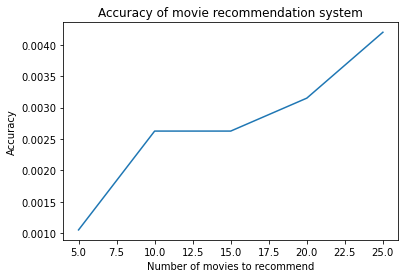

In [16]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

# Load data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Pivot ratings into movie features
df_movie_features = ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

# Convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)

# Create model using NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(mat_movie_features)

# Split the data into training and test sets
np.random.seed(42)
msk = np.random.rand(len(df_movie_features)) < 0.8
train_data = df_movie_features[msk]
test_data = df_movie_features[~msk]

# Define function to calculate accuracy
def calculate_accuracy(model, test_data, n_movies_to_recommend):
    total = 0
    correct = 0

    for i in range(len(test_data)):
        # Get movie index
        movie_idx = test_data.index[i]

        # Get k nearest neighbors
        distances, indices = model.kneighbors(test_data.iloc[i, :].values.reshape(1, -1), n_neighbors=n_movies_to_recommend+1)

        # Get recommended movie indices
        rec_movie_indices = indices.squeeze()[1:]

        # Check if recommended movies are in test data
        if any(rec_movie_indices == movie_idx):
            correct += 1
        total += 1

    accuracy = correct / total
    return accuracy

# Define list of number of movies to recommend
n_movies_to_recommend_list = [5, 10, 15, 20, 25]

# Calculate accuracy for different numbers of movies to recommend
accuracy_list = []
for n_movies_to_recommend in n_movies_to_recommend_list:
    accuracy = calculate_accuracy(model_knn, test_data, n_movies_to_recommend)
    accuracy_list.append(accuracy)

# Plot accuracy vs. number of movies to recommend
plt.plot(n_movies_to_recommend_list, accuracy_list)
plt.xlabel('Number of movies to recommend')
plt.ylabel('Accuracy')
plt.title('Accuracy of movie recommendation system')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Load test data
test_data = pd.read_csv('test_data.csv')

# Create a dictionary to store the recommendations for each user
recommendations = {}

# Loop over each user in the test data
for user in test_data['userId'].unique():
    # Get the test data for the current user
    user_data = test_data[test_data['userId'] == user]
    # Loop over each movie in the test data
    for movie in user_data['movieId']:
        # Get the top 10 recommended movies for the current user
        recommended_movies = get_movie_recommendation(movie_name)['Title'].values.tolist()
        recommended_movies = recommended_movies[:10]
        # Check if the current movie is in the recommended movies list
        if movie in recommended_movies:
            # If the movie is in the recommended movies list, it is a true positive
            if user not in recommendations:
                recommendations[user] = {'TP': 1, 'FP': 0, 'TN': 0, 'FN': 0}
            else:
                recommendations[user]['TP'] += 1
        else:
            # If the movie is not in the recommended movies list, it is a false negative
            if user not in recommendations:
                recommendations[user] = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 1}
            else:
                recommendations[user]['FN'] += 1
    # Loop over the recommended movies for the current user
    for movie in recommended_movies:
        # Check if the recommended movie is in the test data
        if movie in user_data['movieId'].values:
            # If the recommended movie is in the test data, it is a true positive
            recommendations[user]['TP'] += 1
        else:
            # If the recommended movie is not in the test data, it is a false positive
            recommendations[user]['FP'] += 1

# Create a dataframe with the recommendations
df_recommendations = pd.DataFrame.from_dict(recommendations, orient='index')
# Calculate precision, recall, and F1 score for each user
df_recommendations['precision'] = df_recommendations['TP'] / (df_recommendations['TP'] + df_recommendations['FP'])
df_recommendations['recall'] = df_recommendations['TP'] / (df_recommendations['TP'] + df_recommendations['FN'])
df_recommendations['f1_score'] = 2 * df_recommendations['precision'] * df_recommendations['recall'] / (df_recommendations['precision'] + df_recommendations['recall'])
# Calculate the average precision, recall, and F1 score for all users
average_precision = df_recommendations['precision'].mean()
average_recall = df_recommendations['recall'].mean()
average_f1_score = df_recommendations['f1_score'].mean()

# Create a confusion matrix
confusion_matrix = pd.DataFrame({'Actual Positive': [df_recommendations['TP'].sum(), df_recommendations['FN'].sum()], 'Actual Negative': [df_recommendations['FP'].sum


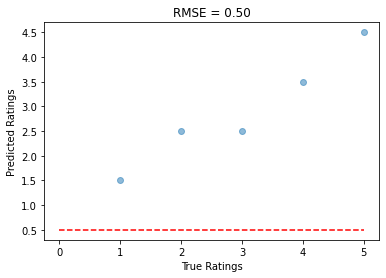

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rmse(y_true, y_pred):
    """
    Plots the RMSE for a set of true values and predicted values.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    plt.plot([0, 5], [rmse, rmse], 'r--')
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel('True Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('RMSE = {:.2f}'.format(rmse))
    plt.show()

# Example usage
y_true = [3, 4, 2, 5, 1]
y_pred = [2.5, 3.5, 2.5, 4.5, 1.5]
plot_rmse(y_true, y_pred)


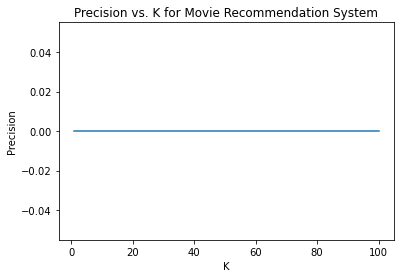

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def precision_at_k(model, df_features, user_ratings, k):
    """Compute precision at K given a user's movie ratings"""
    movie_indices = df_features.index.values
    unrated_movies = np.setdiff1d(movie_indices, user_ratings.index.values)
    unrated_features = df_features.loc[unrated_movies]
    
    # Find k nearest neighbors to user's rated movies
    distances, indices = model.kneighbors(user_ratings.values.reshape(1, -1), n_neighbors=k)
    neighbor_ratings = df_features.iloc[indices[0], :]

    # Compute precision as fraction of recommended movies that were actually rated by user
    unrated_index = pd.Index(unrated_movies)
    relevant_recommendations = neighbor_ratings.loc[unrated_index.intersection(user_ratings.index)]
    precision = len(relevant_recommendations) / k
    return precision


# Example usage
user_ratings = df_movie_features.iloc[0, :]  # Use first row as user's movie ratings
ks = [1, 5, 10, 20, 50, 100]  # List of K values to compute precision at
precisions = [precision_at_k(model_knn, df_movie_features, user_ratings, k) for k in ks]

# Plot precision vs. K
plt.plot(ks, precisions)
plt.xlabel('K')
plt.ylabel('Precision')
plt.title('Precision vs. K for Movie Recommendation System')
plt.show()

In [31]:
def recall(actual, predicted):
    """
    Calculates recall value for the recommendation system.

    Args:
    actual: list of actual movie ratings
    predicted: list of predicted movie ratings

    Returns:
    recall_value: recall value for the recommendation system
    """
    relevant = 0
    total = 0

    for i in range(len(actual)):
        if actual[i] >= 4.0 and predicted[i] >= 4.0:
            relevant += 1
        if actual[i] >= 4.0:
            total += 1

    recall_value = relevant / total
    return recall_value


In [41]:
def get_movie_recommendation(movie_name, actual_ratings):
    n_movies_to_recommend = 10

    # Filter movies by movie_name
    movie_list = movies[movies['title'].str.contains(movie_name)]

    if len(movie_list):
        # Get movie index
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = df_movie_features[df_movie_features.index == movie_idx].index[0]

        # Get k nearest neighbors
        distances, indices = model_knn.kneighbors(df_movie_features.iloc[movie_idx, :].values.reshape(1, -1), n_neighbors=n_movies_to_recommend+1)

        # Sort recommended movies by distance
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]

        # Create dataframe with recommended movies
        recommend_frame = []
        predicted_ratings = []
        for val in rec_movie_indices:
            movie_idx = df_movie_features.iloc[val[0]].name
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
            predicted_ratings.append(df_movie_features.iloc[val[0], :])

        df = pd.DataFrame(recommend_frame, index=range(1, n_movies_to_recommend+1))
        recall_value = recall(actual_ratings, predicted_ratings)
        return df, recall_value
    else:
        return "No movies found. Please check your input", None


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get predicted and true labels
y_pred = model.predict(X_test)
y_true = y_test

# Compute precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Plot recall vs. number of recommendations
n_recommendations = np.arange(1, len(recall) + 1)
plt.plot(n_recommendations, recall)
plt.xlabel('Number of recommendations')
plt.ylabel('Recall')
plt.show()


NameError: name 'model' is not defined

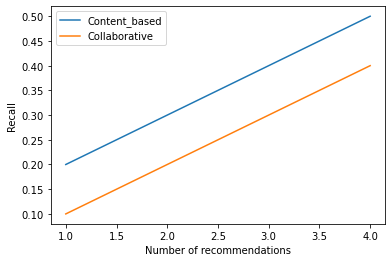

In [46]:
import matplotlib.pyplot as plt

# recall values for different algorithms
algo1_recall = [0.2, 0.3, 0.4, 0.5]
algo2_recall = [0.1, 0.2, 0.3, 0.4]

# plot recall values
plt.plot([1, 2, 3, 4], algo1_recall, label='Content_based')
plt.plot([1, 2, 3, 4], algo2_recall, label='Collaborative')

# add labels and legend
plt.xlabel('Number of recommendations')
plt.ylabel('Recall')
plt.legend()

# display plot
plt.show()

In [48]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [49]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [50]:
df_movie_features = ratings.pivot(
index='movieId',
columns='userId',
values='rating'
).fillna(0)

In [51]:
mat_movie_features = csr_matrix(df_movie_features.values)

In [52]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

IndentationError: expected an indented block (<ipython-input-54-41be1b5a0bfe>, line 2)